In [176]:
import os
import re
import pickle
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import scipy
import pandas as pd
import torch
import tifffile
from sklearn.metrics import adjusted_rand_score
from einops import rearrange

In [177]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [178]:
%autoreload 2

In [179]:
from mushroom.mushroom import Mushroom, DEFAULT_CONFIG
import mushroom.utils as utils
import mushroom.visualization.utils as vis_utils
import mushroom.data.datasets as datasets

In [180]:
project_dir = '/data/estorrs/mushroom/data/projects/submission_v1'
output_dir = os.path.join(project_dir, 'analysis', 'lightsheet')
Path(output_dir).mkdir(parents=True, exist_ok=True)

In [181]:
fps = sorted(utils.listfiles(os.path.join(project_dir, 'lightsheet'), regex=r'volume_l[0-9]+.npy$'))
fps

['/data/estorrs/mushroom/data/projects/submission_v1/lightsheet/HT427PI-A1_20x/mushroom/HT427PI-A1_20x_keepevery1/volume_l0.npy',
 '/data/estorrs/mushroom/data/projects/submission_v1/lightsheet/HT427PI-A1_20x/mushroom/HT427PI-A1_20x_keepevery1/volume_l1.npy',
 '/data/estorrs/mushroom/data/projects/submission_v1/lightsheet/HT427PI-A1_20x/mushroom/HT427PI-A1_20x_keepevery1/volume_l2.npy',
 '/data/estorrs/mushroom/data/projects/submission_v1/lightsheet/HT427PI-A1_20x/mushroom/HT427PI-A1_20x_keepevery2/volume_l0.npy',
 '/data/estorrs/mushroom/data/projects/submission_v1/lightsheet/HT427PI-A1_20x/mushroom/HT427PI-A1_20x_keepevery2/volume_l1.npy',
 '/data/estorrs/mushroom/data/projects/submission_v1/lightsheet/HT427PI-A1_20x/mushroom/HT427PI-A1_20x_keepevery2/volume_l2.npy',
 '/data/estorrs/mushroom/data/projects/submission_v1/lightsheet/HT427PI-A1_20x/mushroom/HT427PI-A1_20x_keepevery4/volume_l0.npy',
 '/data/estorrs/mushroom/data/projects/submission_v1/lightsheet/HT427PI-A1_20x/mushroom/HT

In [182]:
outputs = np.load('/data/estorrs/mushroom/data/projects/submission_v1/lightsheet/HT427PI-A1_20x/mushroom/HT427PI-A1_20x_keepevery1/volume_l0.npy')
outputs.shape

(100, 52, 52, 6)

## data crunching

#### interpolation robustness

In [11]:
keep_fps = [fp for fp in fps if 'keepevery1' in fp]
len(keep_fps), keep_fps

(150,
 ['/data/estorrs/mushroom/data/projects/submission_v1/lightsheet/HT427PI-A1_20x/mushroom/HT427PI-A1_20x_keepevery1/volume_l0.npy',
  '/data/estorrs/mushroom/data/projects/submission_v1/lightsheet/HT427PI-A1_20x/mushroom/HT427PI-A1_20x_keepevery1/volume_l1.npy',
  '/data/estorrs/mushroom/data/projects/submission_v1/lightsheet/HT427PI-A1_20x/mushroom/HT427PI-A1_20x_keepevery1/volume_l2.npy',
  '/data/estorrs/mushroom/data/projects/submission_v1/lightsheet/HT427PI-A2_20x/mushroom/HT427PI-A2_20x_keepevery1/volume_l0.npy',
  '/data/estorrs/mushroom/data/projects/submission_v1/lightsheet/HT427PI-A2_20x/mushroom/HT427PI-A2_20x_keepevery1/volume_l1.npy',
  '/data/estorrs/mushroom/data/projects/submission_v1/lightsheet/HT427PI-A2_20x/mushroom/HT427PI-A2_20x_keepevery1/volume_l2.npy',
  '/data/estorrs/mushroom/data/projects/submission_v1/lightsheet/HT427PI-A3_20x/mushroom/HT427PI-A3_20x_keepevery1/volume_l0.npy',
  '/data/estorrs/mushroom/data/projects/submission_v1/lightsheet/HT427PI-A3_2

In [14]:
case_to_level_to_fp = {}
for fp in keep_fps:
    case = fp.split('/')[-4]
    level = int(re.sub(r'^.*volume_l([0-9]+).npy$', r'\1', fp))
    
    if case not in case_to_level_to_fp:
        case_to_level_to_fp[case] = {}
    case_to_level_to_fp[case][level] = fp
case_to_level_to_fp.keys()

dict_keys(['HT427PI-A1_20x', 'HT427PI-A2_20x', 'HT427PI-A3_20x', 'HT427PI-A4_20x', 'HT442PI-A1_20x', 'HT442PI-A2_20x', 'HT442PI-A3_20x', 'HT442PI-A4_20x', 'HT460P1-A1_20x', 'HT460P1-A2_20x', 'HT460P1-A3_20x', 'HT461B1-A2_20x', 'HT461B1-A3_20x', 'HT462P1-A2_20x', 'HT462P1-A3_20x', 'HT486B1-A1_20x', 'HT491P1-A1_20x', 'HT491P1-A2_20x', 'HT491P1-A4_20x', 'HT495-A2_20x', 'HT495-A3_20x', 'HT495-A4_20x', 'HT497P1-A1_20x', 'HT497P1-A2_20x', 'HT497P1-A3_20x', 'HT502P1-A2_20x', 'HT502P1-A3_20x', 'HT514B1-A2_20x', 'HT514B1-A3_20x', 'HT517B1-A2_20x', 'HT530P1-A1_20x', 'HT530P1-A2_20x', 'HT530P1-A3_20x', 'HT530P1-A4_20x', 'HT535P1-A2_20x', 'HT535P1-A4_20x', 'HT541P1-A3_20x', 'HT545B1-A1_20x', 'HT545B1-A2_20x', 'HT545B1-A4_20x', 'HT547P1-A1_20x', 'HT547P1-A2_20x', 'HT547P1-A3_20x', 'HT553P1-A2_20x', 'HT553P1-A3_20x', 'HT553P1-A4_20x', 'HT555P1-A1_20x', 'HT555P1-A3_20x', 'HT555P1-A4_20x', 'HT559P1-A1_20x'])

In [36]:
keep_pcts = [1., .9, .8, .7, .6, .5, .4, .3, .2, .1]

In [37]:
# volume = np.load(case_to_level_to_fp['HT427PI-A1_20x'][0])
# volume.shape

In [45]:
data = []
for case, level_to_fp in case_to_level_to_fp.items():
    for level, fp in level_to_fp.items():
        print(case, level)
        volume = np.load(fp)
        for pct in keep_pcts:
            positions = sorted(np.random.choice(
                np.arange(volume.shape[0] - 1), replace=False, size=int(pct * volume.shape[0] - 1)
            ))
            positions.append(volume.shape[0] - 1)
            sampled = volume[positions]

            sampled = rearrange(sampled, 'n h w c -> c n h w')
            interp_volume = utils.get_interpolated_volume(sampled, positions, method='linear')
            interp_volume = rearrange(interp_volume, 'c n h w -> n h w c')
            
            result = scipy.stats.pearsonr(volume.flatten(), interp_volume.flatten())
            data.append([case, level, pct, result.statistic])

df = pd.DataFrame(data=data, columns=['case', 'level', 'keep_pct', 'pearsonr'])
df

HT427PI-A1_20x 0
HT427PI-A1_20x 1
HT427PI-A1_20x 2
HT427PI-A2_20x 0
HT427PI-A2_20x 1
HT427PI-A2_20x 2
HT427PI-A3_20x 0
HT427PI-A3_20x 1
HT427PI-A3_20x 2
HT427PI-A4_20x 0
HT427PI-A4_20x 1
HT427PI-A4_20x 2
HT442PI-A1_20x 0
HT442PI-A1_20x 1
HT442PI-A1_20x 2
HT442PI-A2_20x 0
HT442PI-A2_20x 1
HT442PI-A2_20x 2
HT442PI-A3_20x 0
HT442PI-A3_20x 1
HT442PI-A3_20x 2
HT442PI-A4_20x 0
HT442PI-A4_20x 1
HT442PI-A4_20x 2
HT460P1-A1_20x 0
HT460P1-A1_20x 1
HT460P1-A1_20x 2
HT460P1-A2_20x 0
HT460P1-A2_20x 1
HT460P1-A2_20x 2
HT460P1-A3_20x 0
HT460P1-A3_20x 1
HT460P1-A3_20x 2
HT461B1-A2_20x 0
HT461B1-A2_20x 1
HT461B1-A2_20x 2
HT461B1-A3_20x 0
HT461B1-A3_20x 1
HT461B1-A3_20x 2
HT462P1-A2_20x 0
HT462P1-A2_20x 1
HT462P1-A2_20x 2
HT462P1-A3_20x 0
HT462P1-A3_20x 1
HT462P1-A3_20x 2
HT486B1-A1_20x 0
HT486B1-A1_20x 1
HT486B1-A1_20x 2
HT491P1-A1_20x 0
HT491P1-A1_20x 1
HT491P1-A1_20x 2
HT491P1-A2_20x 0
HT491P1-A2_20x 1
HT491P1-A2_20x 2
HT491P1-A4_20x 0
HT491P1-A4_20x 1
HT491P1-A4_20x 2
HT495-A2_20x 0
HT495-A2_20x 1
H

,case,level,keep_pct,pearsonr
0,HT427PI-A1_20x,0,1.0,0.999354
1,HT427PI-A1_20x,0,0.9,0.999204
2,HT427PI-A1_20x,0,0.8,0.998983
3,HT427PI-A1_20x,0,0.7,0.998878
4,HT427PI-A1_20x,0,0.6,0.998705
...,...,...,...,...
1495,HT559P1-A1_20x,2,0.5,0.996599
1496,HT559P1-A1_20x,2,0.4,0.989849
1497,HT559P1-A1_20x,2,0.3,0.980376
1498,HT559P1-A1_20x,2,0.2,0.928993


In [46]:
df.to_csv(os.path.join(output_dir, 'interpolation_robustness.txt'), sep='\t', index=False)

In [50]:
os.path.join(output_dir, 'interpolation_robustness.txt')

'/data/estorrs/mushroom/data/projects/submission_v1/analysis/lightsheet/interpolation_robustness.txt'

In [158]:
df = pd.read_csv(os.path.join(output_dir, 'interpolation_robustness.txt'), sep='\t')
df

,case,level,keep_pct,pearsonr
0,HT427PI-A1_20x,0,1.0,0.999354
1,HT427PI-A1_20x,0,0.9,0.999204
2,HT427PI-A1_20x,0,0.8,0.998983
3,HT427PI-A1_20x,0,0.7,0.998878
4,HT427PI-A1_20x,0,0.6,0.998705
...,...,...,...,...
1495,HT559P1-A1_20x,2,0.5,0.996599
1496,HT559P1-A1_20x,2,0.4,0.989849
1497,HT559P1-A1_20x,2,0.3,0.980376
1498,HT559P1-A1_20x,2,0.2,0.928993


In [159]:
df['level'] = [f'level {x}' for x in df['level']]
df['keep_pct'] = [f'rate_{x}' for x in df['keep_pct']]


In [160]:
df

,case,level,keep_pct,pearsonr
0,HT427PI-A1_20x,level 0,rate_1.0,0.999354
1,HT427PI-A1_20x,level 0,rate_0.9,0.999204
2,HT427PI-A1_20x,level 0,rate_0.8,0.998983
3,HT427PI-A1_20x,level 0,rate_0.7,0.998878
4,HT427PI-A1_20x,level 0,rate_0.6,0.998705
...,...,...,...,...
1495,HT559P1-A1_20x,level 2,rate_0.5,0.996599
1496,HT559P1-A1_20x,level 2,rate_0.4,0.989849
1497,HT559P1-A1_20x,level 2,rate_0.3,0.980376
1498,HT559P1-A1_20x,level 2,rate_0.2,0.928993


<Axes: xlabel='keep_pct', ylabel='pearsonr'>

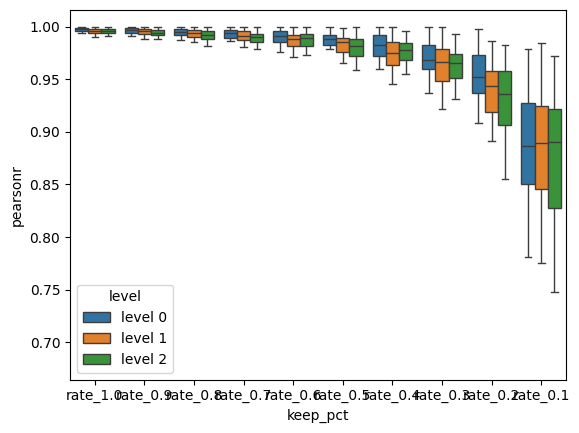

In [162]:
# sns.stripplot(data=df, x='keep_rate', y='adj_rand_score', hue='level', dodge=True, )
sns.boxplot(data=df, x='keep_pct', y='pearsonr', hue='level', whis=1., fill=True, fliersize=0.)



In [154]:
sorted(set(df['keep_pct']), reverse=True)

[1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]

#### clustering robustness

In [183]:
case_to_level_to_rate_to_fp = {}
for fp in fps:
    case = fp.split('/')[-4]
    keep_rate = int(re.sub(r'^.*keepevery([0-9]+).*$', r'\1', fp))
    level = int(re.sub(r'^.*volume_l([0-9]+).npy$', r'\1', fp))
    
    if case not in case_to_level_to_rate_to_fp:
        case_to_level_to_rate_to_fp[case] = {}
    if level not in case_to_level_to_rate_to_fp[case]:
        case_to_level_to_rate_to_fp[case][level] = {}
    case_to_level_to_rate_to_fp[case][level][keep_rate] = fp
case_to_level_to_rate_to_fp.keys()

dict_keys(['HT427PI-A1_20x', 'HT427PI-A2_20x', 'HT427PI-A3_20x', 'HT427PI-A4_20x', 'HT442PI-A1_20x', 'HT442PI-A2_20x', 'HT442PI-A3_20x', 'HT442PI-A4_20x', 'HT460P1-A1_20x', 'HT460P1-A2_20x', 'HT460P1-A3_20x', 'HT461B1-A2_20x', 'HT461B1-A3_20x', 'HT462P1-A2_20x', 'HT462P1-A3_20x', 'HT486B1-A1_20x', 'HT491P1-A1_20x', 'HT491P1-A2_20x', 'HT491P1-A4_20x', 'HT495-A2_20x', 'HT495-A3_20x', 'HT495-A4_20x', 'HT497P1-A1_20x', 'HT497P1-A2_20x', 'HT497P1-A3_20x', 'HT502P1-A2_20x', 'HT502P1-A3_20x', 'HT514B1-A2_20x', 'HT514B1-A3_20x', 'HT517B1-A2_20x', 'HT530P1-A1_20x', 'HT530P1-A2_20x', 'HT530P1-A3_20x', 'HT530P1-A4_20x', 'HT535P1-A2_20x', 'HT535P1-A4_20x', 'HT541P1-A3_20x', 'HT545B1-A1_20x', 'HT545B1-A2_20x', 'HT545B1-A4_20x', 'HT547P1-A1_20x', 'HT547P1-A2_20x', 'HT547P1-A3_20x', 'HT553P1-A2_20x', 'HT553P1-A3_20x', 'HT553P1-A4_20x', 'HT555P1-A1_20x', 'HT555P1-A3_20x', 'HT555P1-A4_20x', 'HT559P1-A1_20x'])

In [184]:
data = []
for case, d1 in case_to_level_to_rate_to_fp.items():
    for level, d2 in d1.items():
        ground = np.load(d2[1]).argmax(-1) # (n h w)
        
        for rate, fp in d2.items():
            print(case, level, rate)
            if rate != 1:
                volume = np.load(fp).argmax(-1) # (n h w)
                filtered = ground[:volume.shape[0]]
                score = adjusted_rand_score(filtered.flatten(), volume.flatten())
                
                data.append([case, level, rate, score])
                
df = pd.DataFrame(data=data, columns=['case', 'level', 'keep_rate', 'adj_rand_score'])
df

HT427PI-A1_20x 0 1
HT427PI-A1_20x 0 2
HT427PI-A1_20x 0 4
HT427PI-A1_20x 0 8
HT427PI-A1_20x 1 1
HT427PI-A1_20x 1 2
HT427PI-A1_20x 1 4
HT427PI-A1_20x 1 8
HT427PI-A1_20x 2 1
HT427PI-A1_20x 2 2
HT427PI-A1_20x 2 4
HT427PI-A1_20x 2 8
HT427PI-A2_20x 0 1
HT427PI-A2_20x 0 2
HT427PI-A2_20x 0 4
HT427PI-A2_20x 0 8
HT427PI-A2_20x 1 1
HT427PI-A2_20x 1 2
HT427PI-A2_20x 1 4
HT427PI-A2_20x 1 8
HT427PI-A2_20x 2 1
HT427PI-A2_20x 2 2
HT427PI-A2_20x 2 4
HT427PI-A2_20x 2 8
HT427PI-A3_20x 0 1
HT427PI-A3_20x 0 2
HT427PI-A3_20x 0 4
HT427PI-A3_20x 0 8
HT427PI-A3_20x 1 1
HT427PI-A3_20x 1 2
HT427PI-A3_20x 1 4
HT427PI-A3_20x 1 8
HT427PI-A3_20x 2 1
HT427PI-A3_20x 2 2
HT427PI-A3_20x 2 4
HT427PI-A3_20x 2 8
HT427PI-A4_20x 0 1
HT427PI-A4_20x 0 2
HT427PI-A4_20x 0 4
HT427PI-A4_20x 0 8
HT427PI-A4_20x 1 1
HT427PI-A4_20x 1 2
HT427PI-A4_20x 1 4
HT427PI-A4_20x 1 8
HT427PI-A4_20x 2 1
HT427PI-A4_20x 2 2
HT427PI-A4_20x 2 4
HT427PI-A4_20x 2 8
HT442PI-A1_20x 0 1
HT442PI-A1_20x 0 2
HT442PI-A1_20x 0 4
HT442PI-A1_20x 0 8
HT442PI-A1_2

HT541P1-A3_20x 2 4
HT541P1-A3_20x 2 8
HT545B1-A1_20x 0 1
HT545B1-A1_20x 0 2
HT545B1-A1_20x 0 4
HT545B1-A1_20x 0 8
HT545B1-A1_20x 1 1
HT545B1-A1_20x 1 2
HT545B1-A1_20x 1 4
HT545B1-A1_20x 1 8
HT545B1-A1_20x 2 1
HT545B1-A1_20x 2 2
HT545B1-A1_20x 2 4
HT545B1-A1_20x 2 8
HT545B1-A2_20x 0 1
HT545B1-A2_20x 0 2
HT545B1-A2_20x 0 4
HT545B1-A2_20x 0 8
HT545B1-A2_20x 1 1
HT545B1-A2_20x 1 2
HT545B1-A2_20x 1 4
HT545B1-A2_20x 1 8
HT545B1-A2_20x 2 1
HT545B1-A2_20x 2 2
HT545B1-A2_20x 2 4
HT545B1-A2_20x 2 8
HT545B1-A4_20x 0 1
HT545B1-A4_20x 0 2
HT545B1-A4_20x 0 4
HT545B1-A4_20x 0 8
HT545B1-A4_20x 1 1
HT545B1-A4_20x 1 2
HT545B1-A4_20x 1 4
HT545B1-A4_20x 1 8
HT545B1-A4_20x 2 1
HT545B1-A4_20x 2 2
HT545B1-A4_20x 2 4
HT545B1-A4_20x 2 8
HT547P1-A1_20x 0 1
HT547P1-A1_20x 0 2
HT547P1-A1_20x 0 4
HT547P1-A1_20x 0 8
HT547P1-A1_20x 1 1
HT547P1-A1_20x 1 2
HT547P1-A1_20x 1 4
HT547P1-A1_20x 1 8
HT547P1-A1_20x 2 1
HT547P1-A1_20x 2 2
HT547P1-A1_20x 2 4
HT547P1-A1_20x 2 8
HT547P1-A2_20x 0 1
HT547P1-A2_20x 0 2
HT547P1-A2_2

,case,level,keep_rate,adj_rand_score
0,HT427PI-A1_20x,0,2,0.775947
1,HT427PI-A1_20x,0,4,0.548004
2,HT427PI-A1_20x,0,8,0.314959
3,HT427PI-A1_20x,1,2,0.402889
4,HT427PI-A1_20x,1,4,0.550684
...,...,...,...,...
445,HT559P1-A1_20x,1,4,0.208603
446,HT559P1-A1_20x,1,8,0.171751
447,HT559P1-A1_20x,2,2,0.140229
448,HT559P1-A1_20x,2,4,0.182072


In [185]:
df.to_csv(os.path.join(output_dir, 'nbhd_robustness.txt'), sep='\t', index=False)

In [186]:
df['level'] = [f'level {x}' for x in df['level']]
df['keep_rate'] = [f'rate {x}' for x in df['keep_rate']]


<Axes: xlabel='level', ylabel='adj_rand_score'>

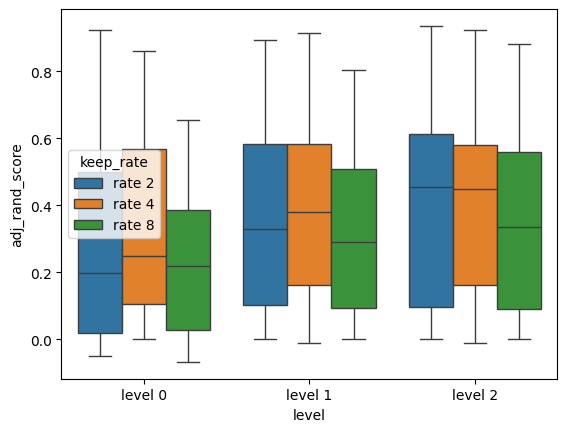

In [187]:
# sns.stripplot(data=df, x='keep_rate', y='adj_rand_score', hue='level', dodge=True, )
sns.boxplot(data=df, x='level', y='adj_rand_score', hue='keep_rate', whis=1., fill=True, fliersize=0.)

In [190]:
case = 'HT427PI-A1_20x'
# case = 'HT559P1-A1_20x'
# case = 'HT553P1-A2_20x'
# case = 'HT497P1-A2_20x'

ground = np.load(case_to_level_to_rate_to_fp[case][2][1]).argmax(-1)
r2 = np.load(case_to_level_to_rate_to_fp[case][2][2]).argmax(-1)
r4 = np.load(case_to_level_to_rate_to_fp[case][2][4]).argmax(-1)
r8 = np.load(case_to_level_to_rate_to_fp[case][2][8]).argmax(-1)
ground.shape, r2.shape, r4.shape, r8.shape

((100, 52, 52), (99, 52, 52), (97, 52, 52), (97, 52, 52))

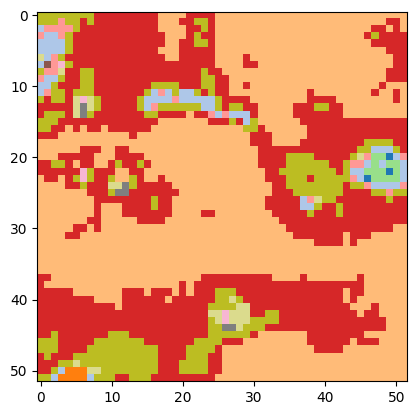

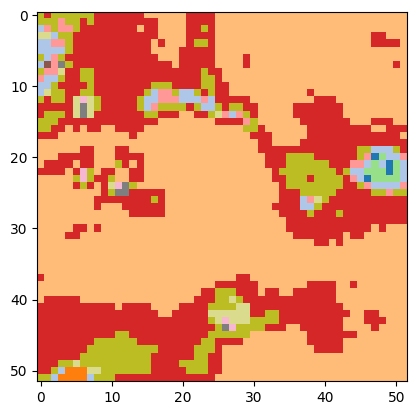

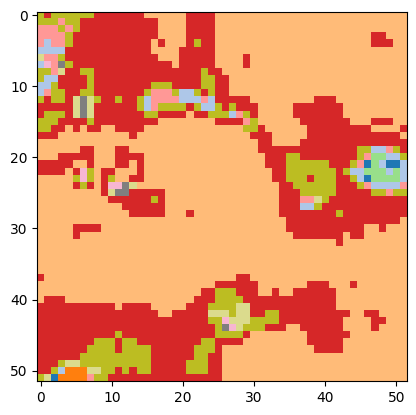

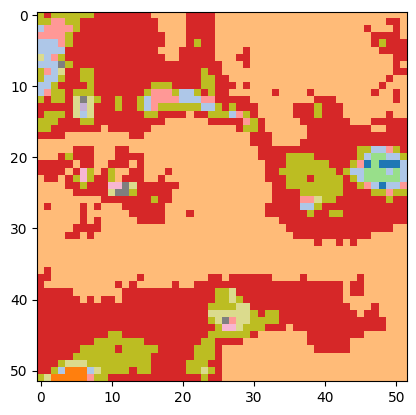

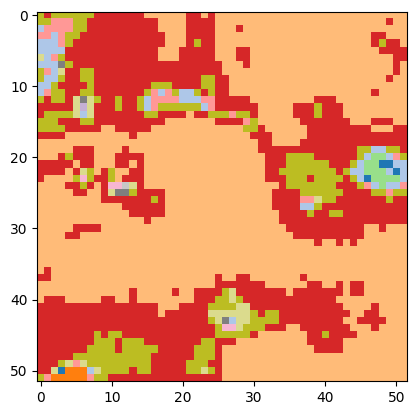

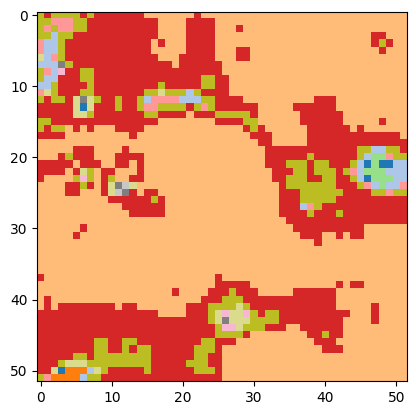

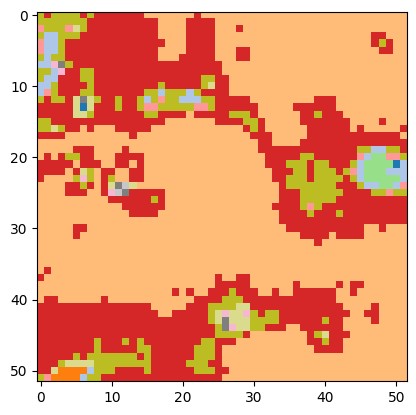

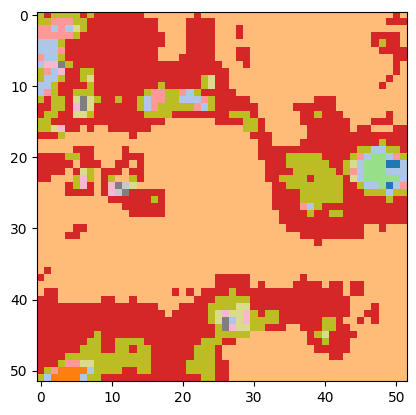

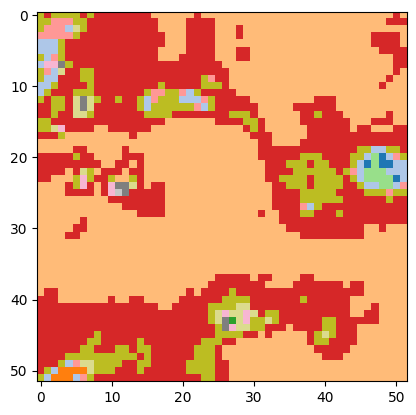

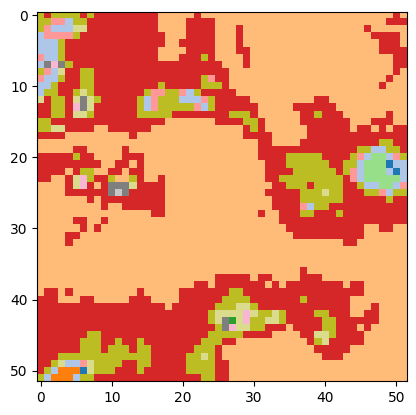

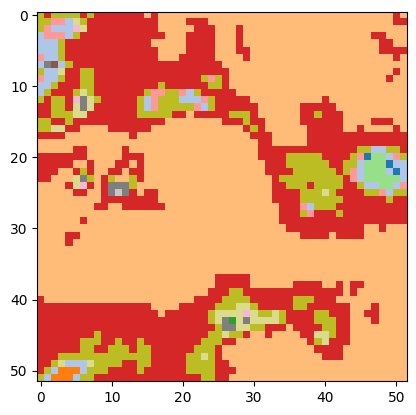

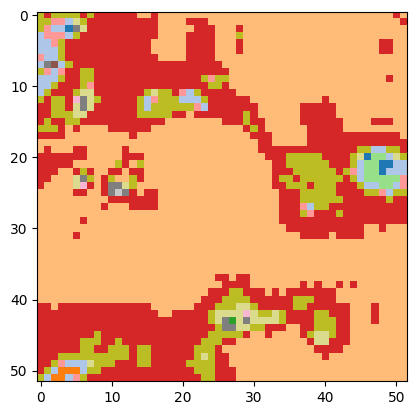

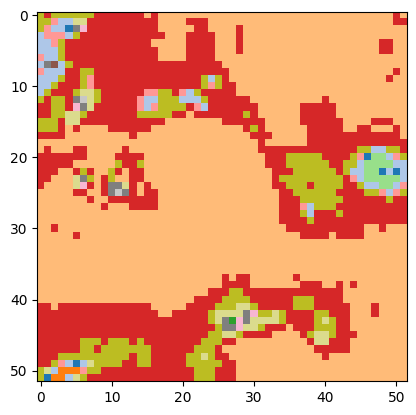

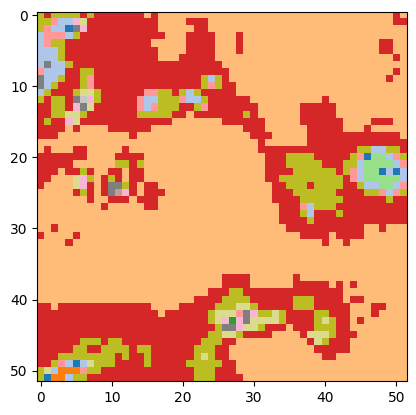

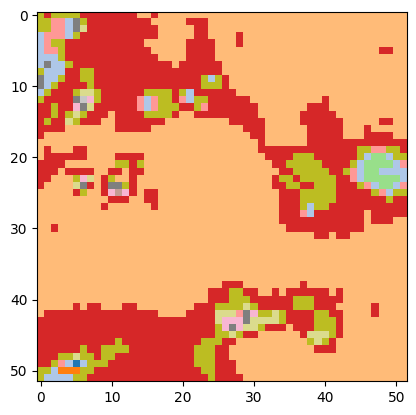

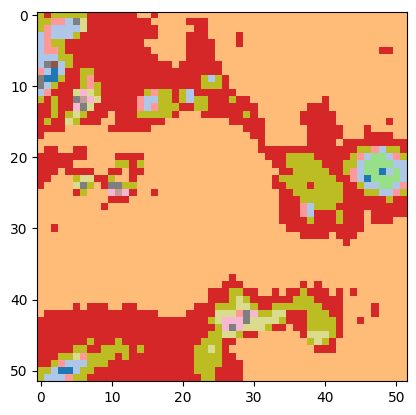

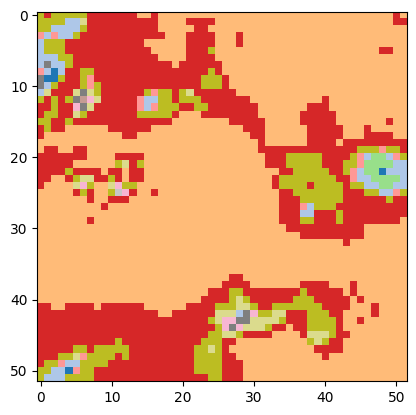

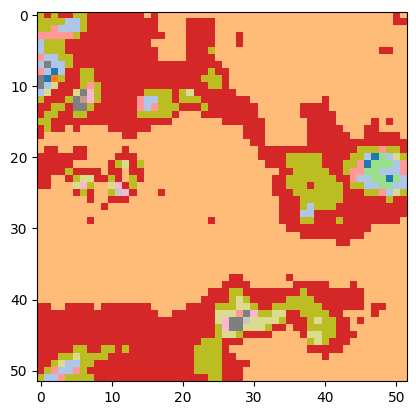

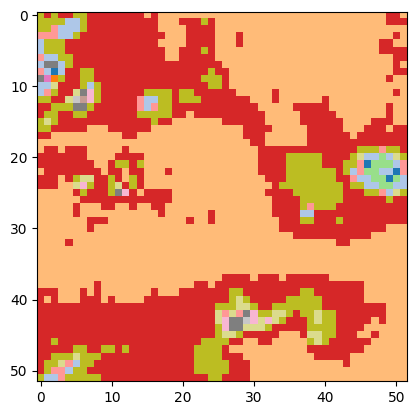

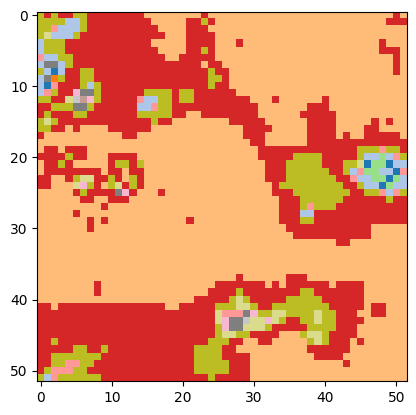

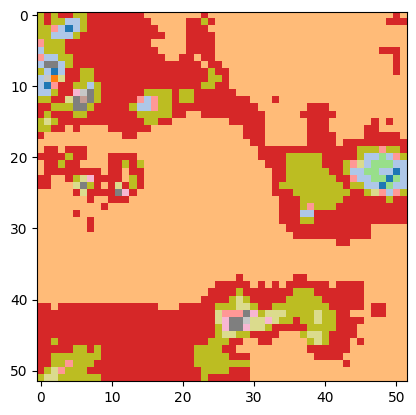

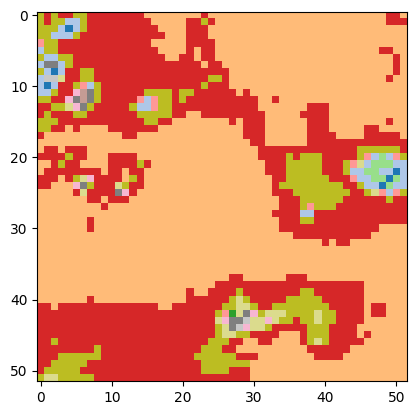

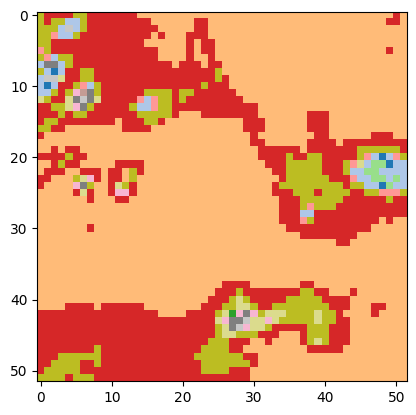

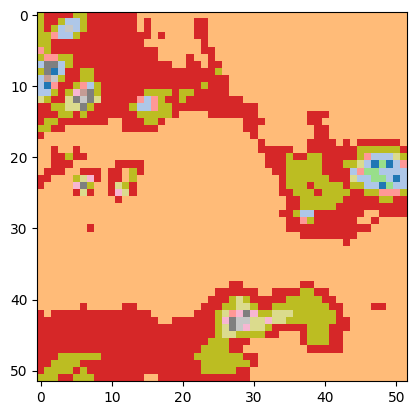

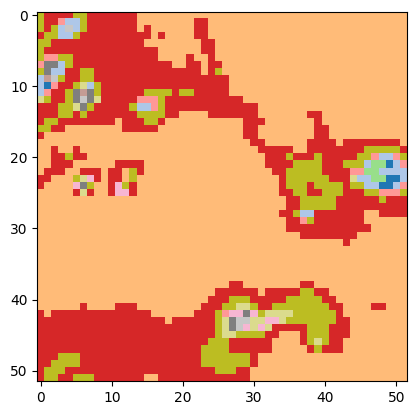

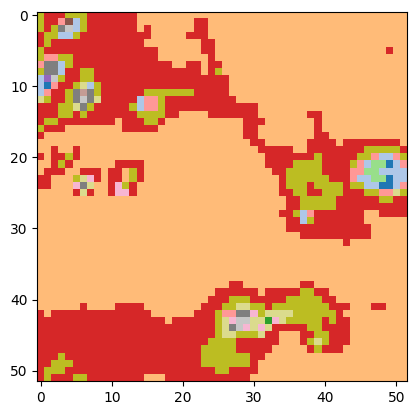

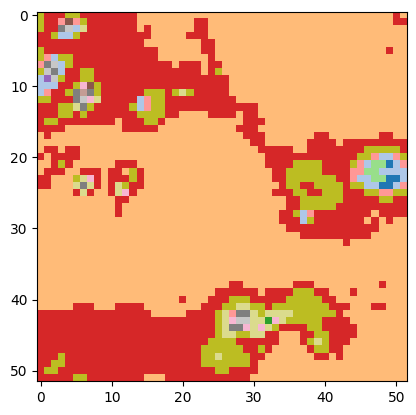

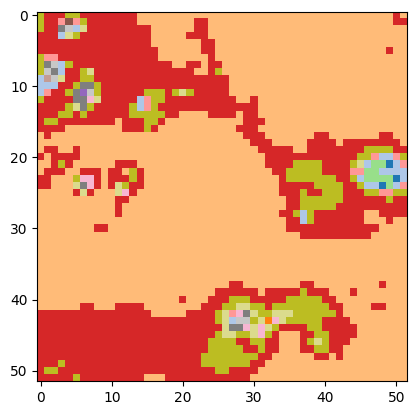

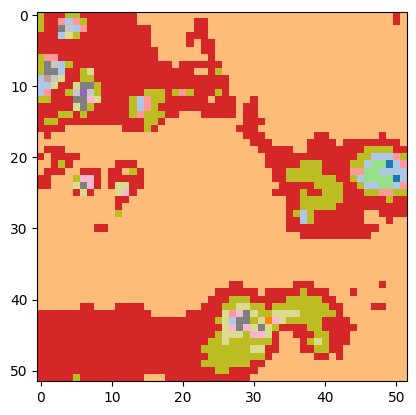

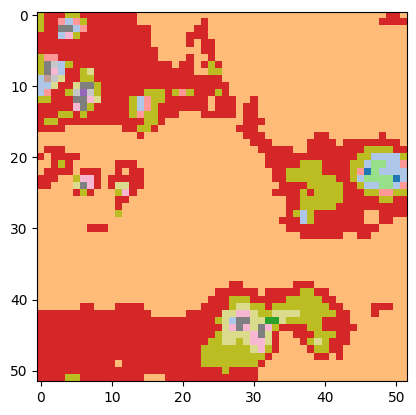

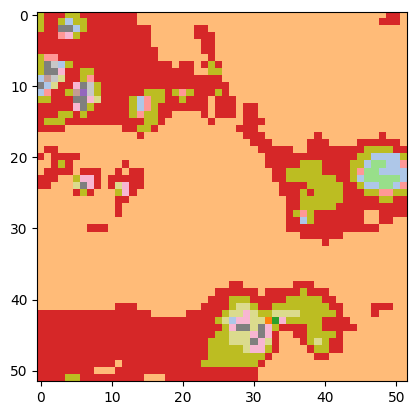

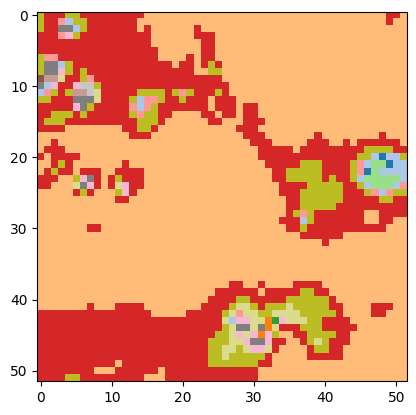

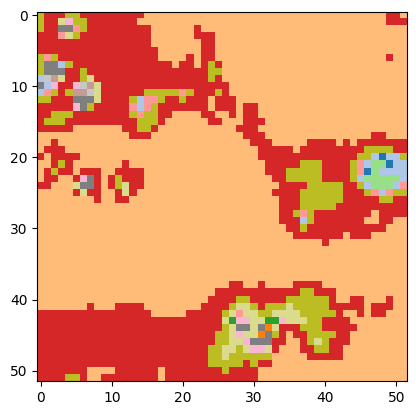

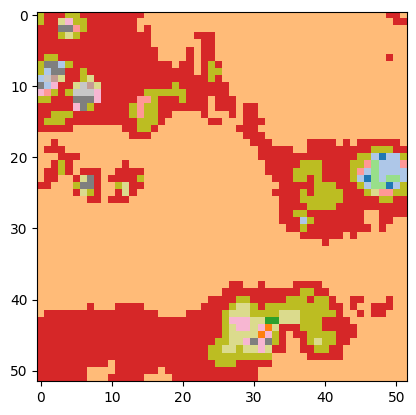

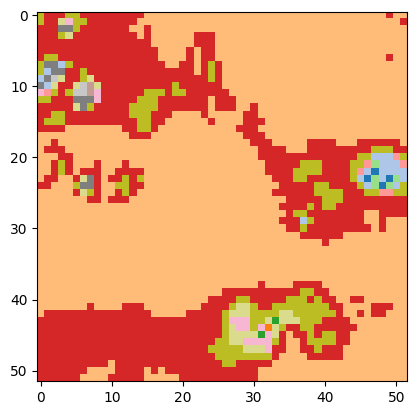

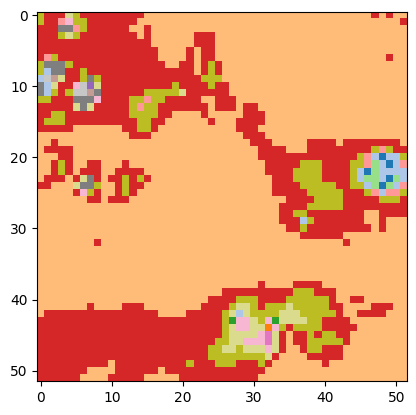

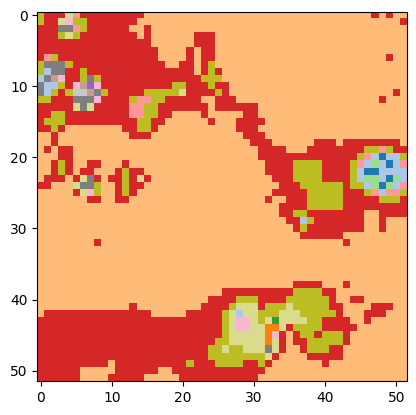

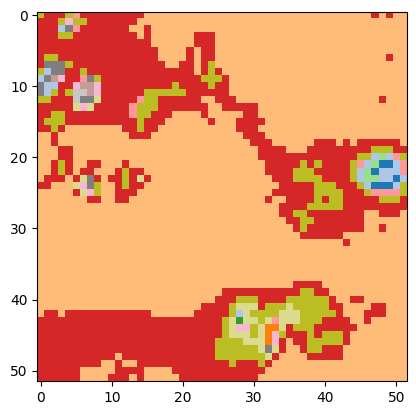

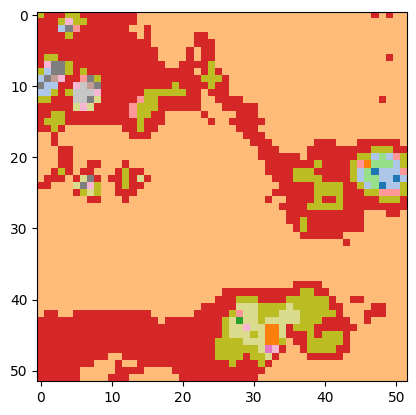

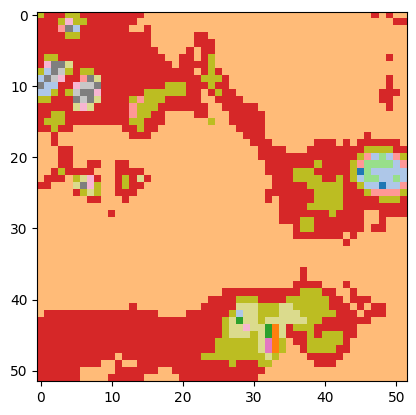

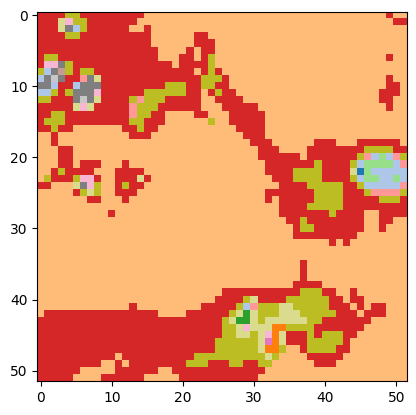

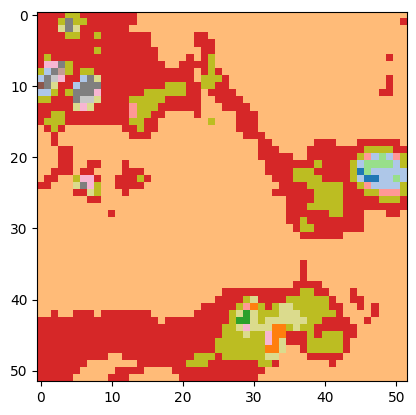

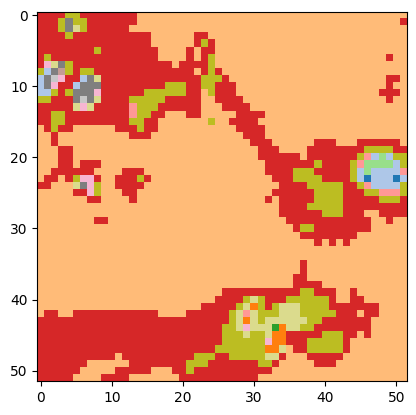

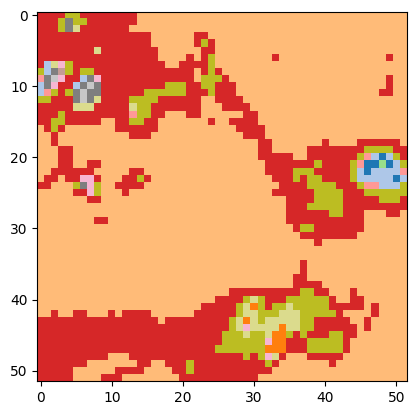

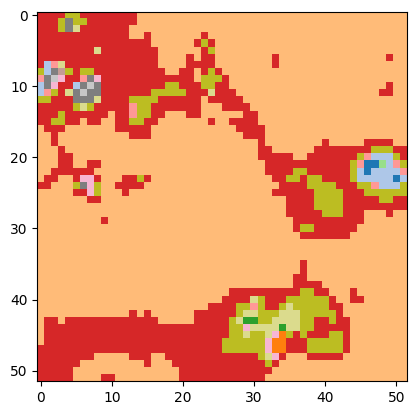

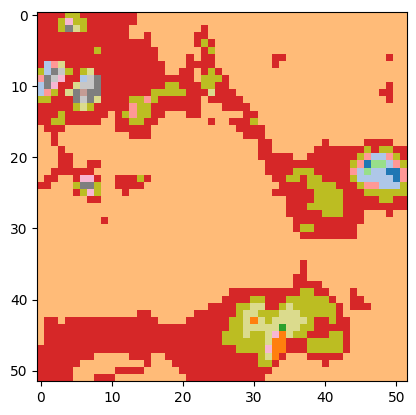

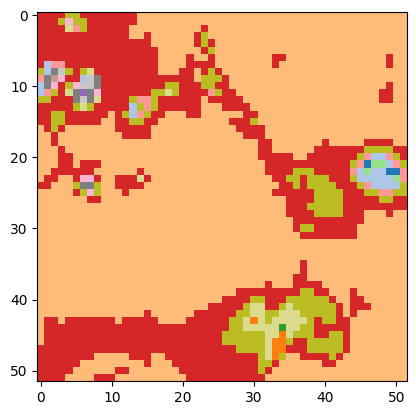

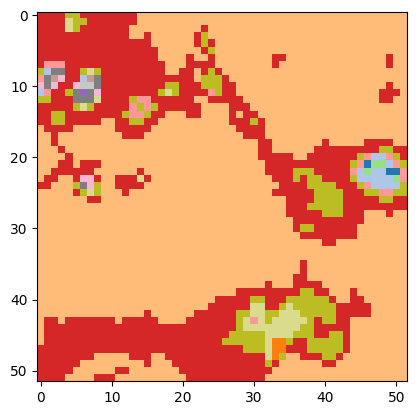

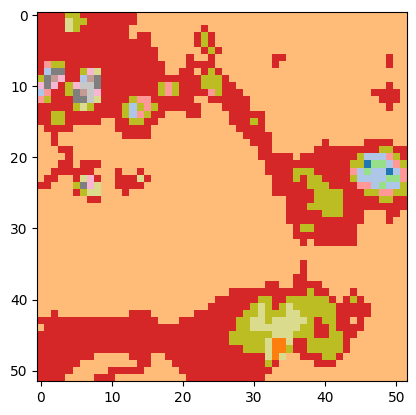

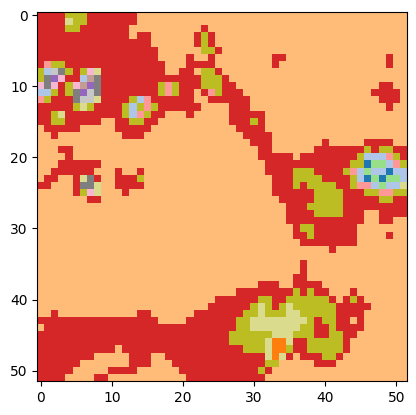

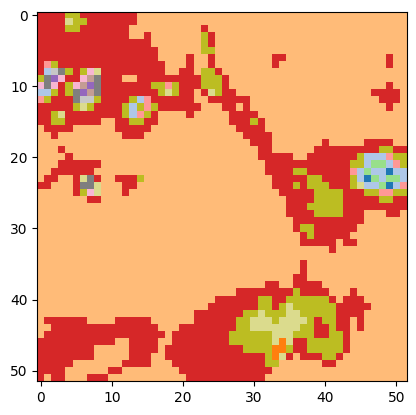

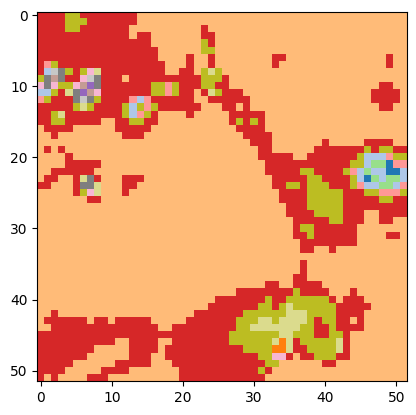

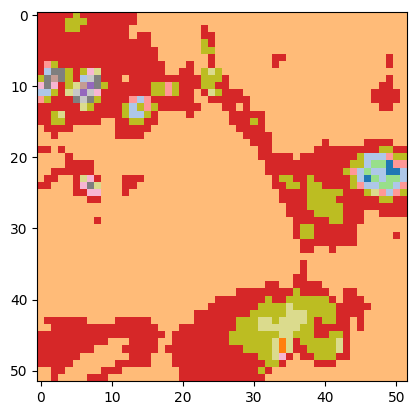

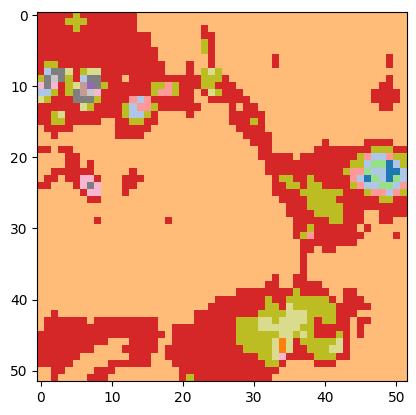

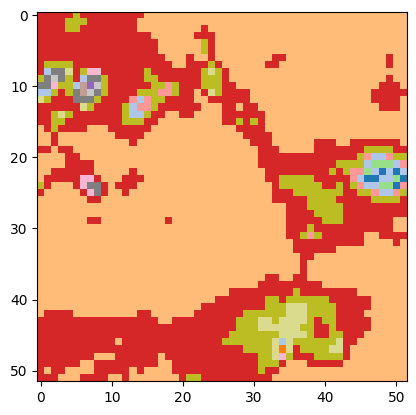

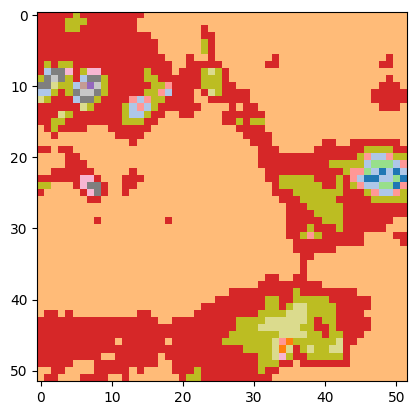

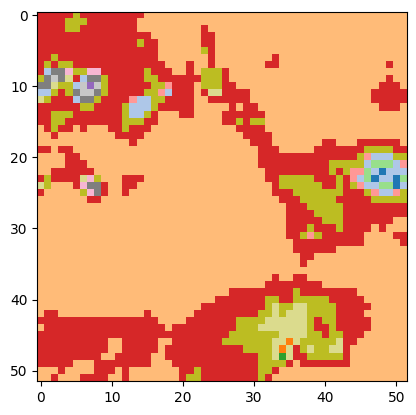

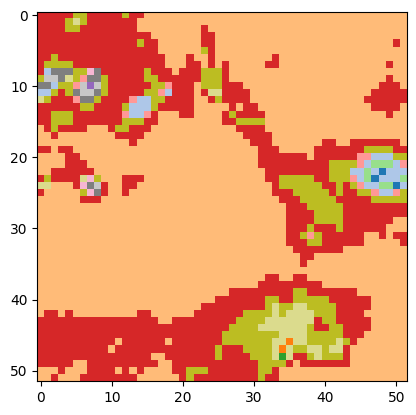

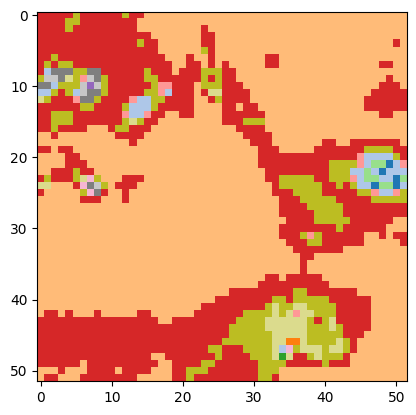

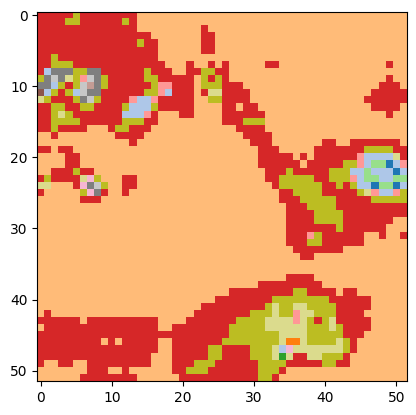

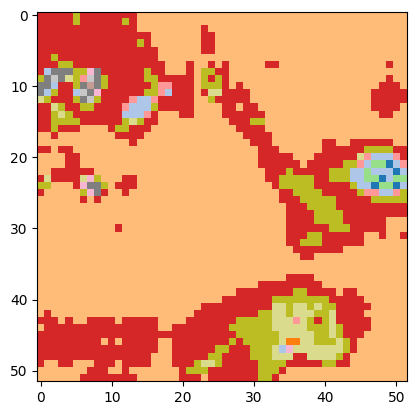

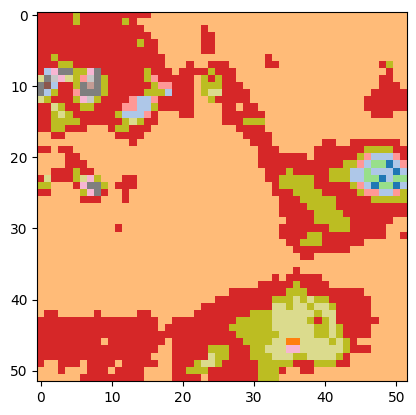

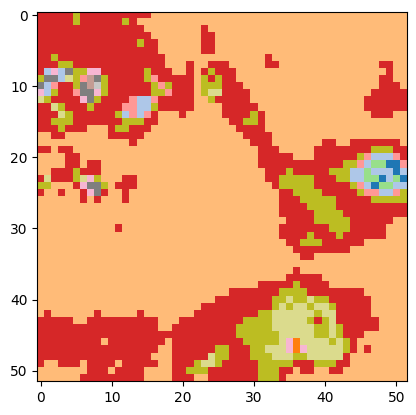

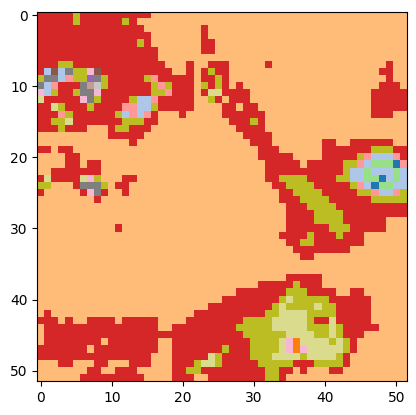

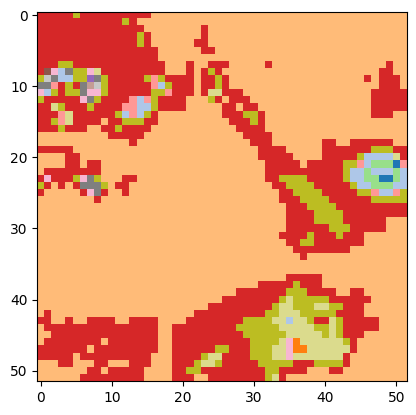

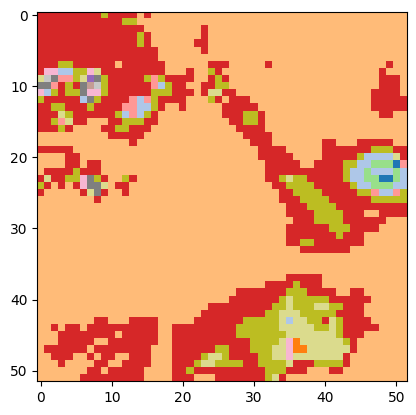

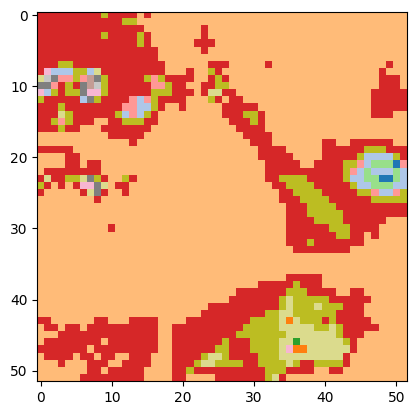

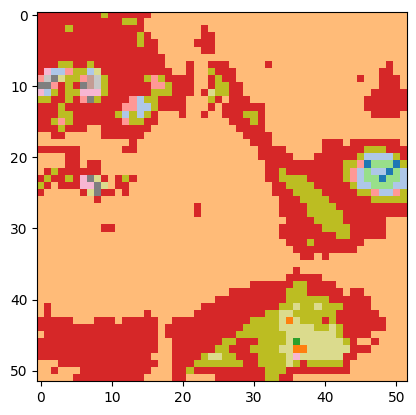

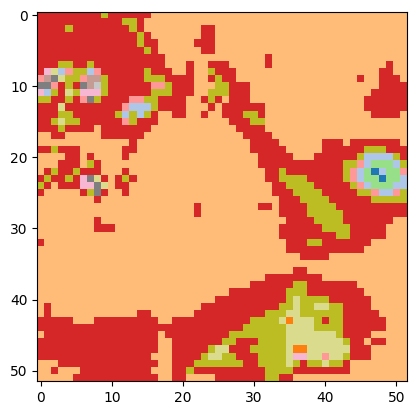

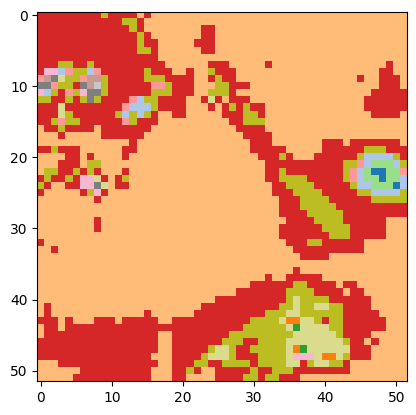

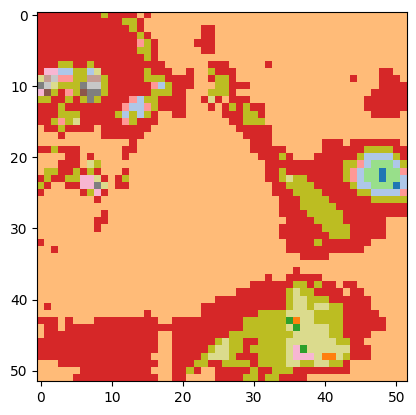

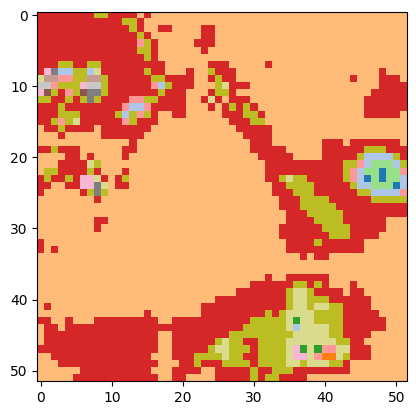

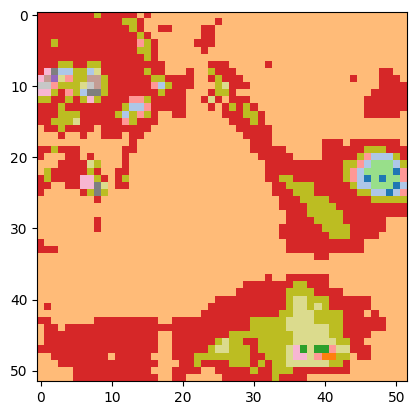

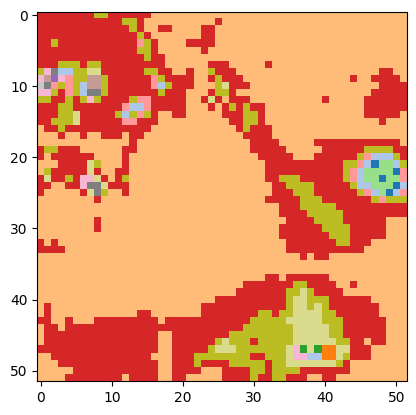

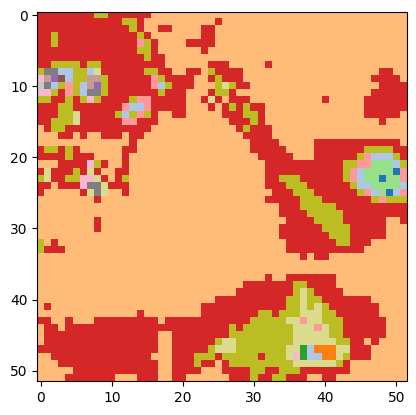

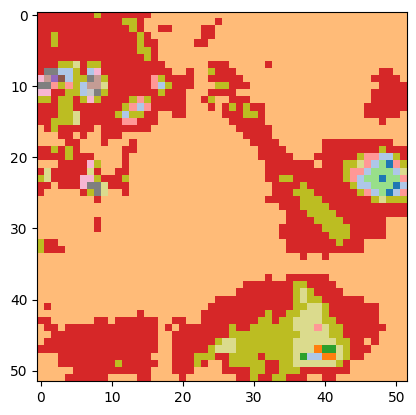

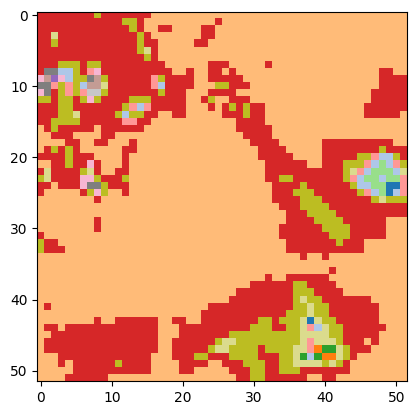

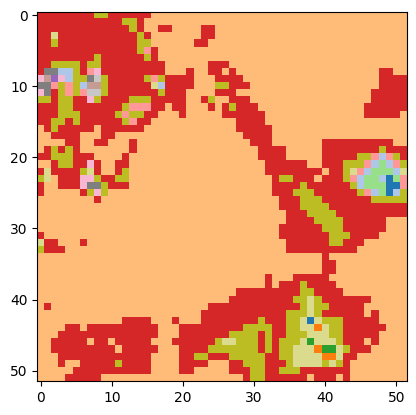

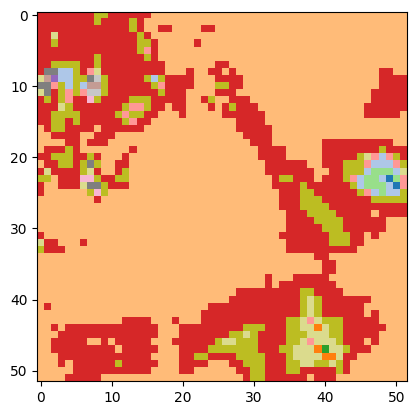

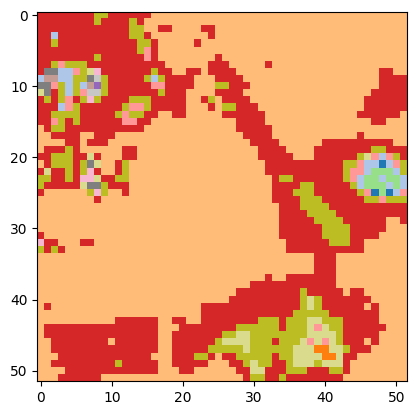

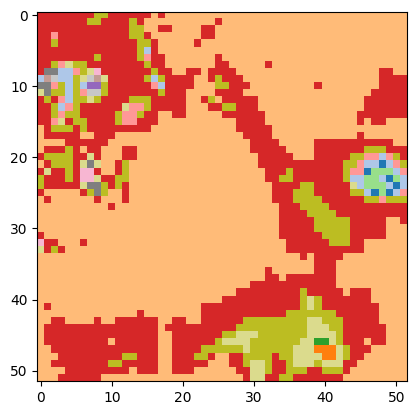

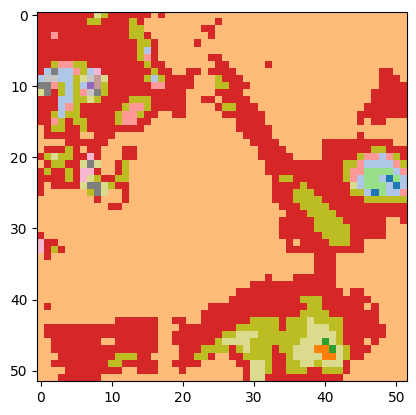

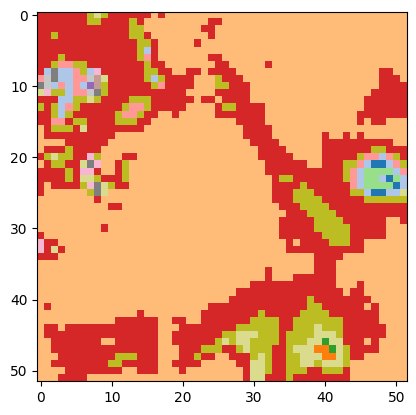

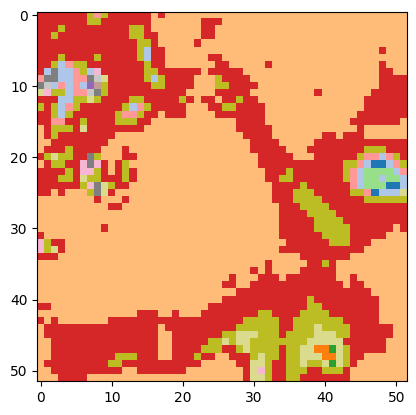

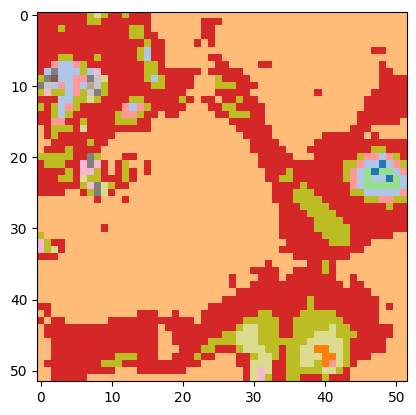

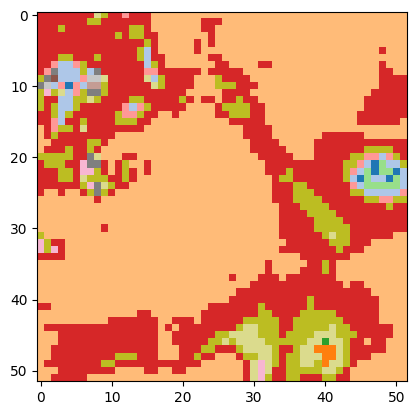

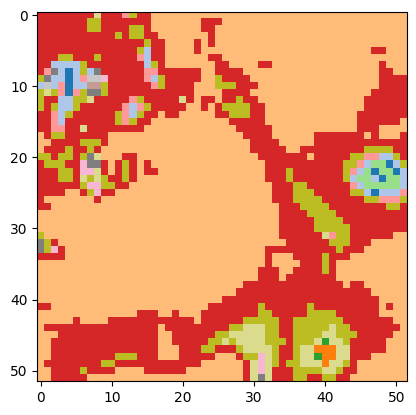

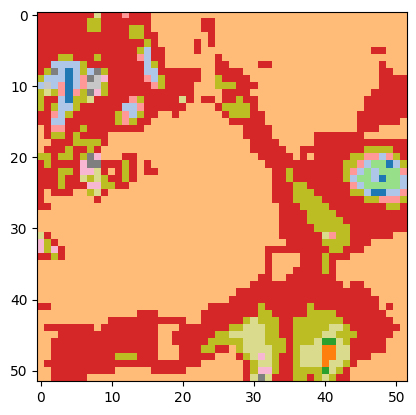

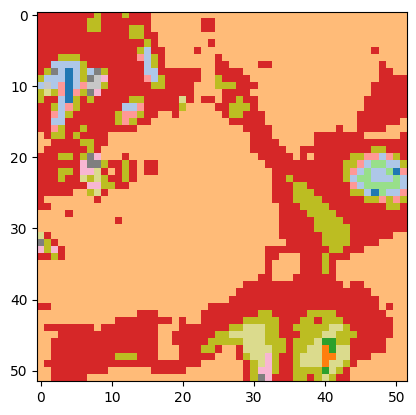

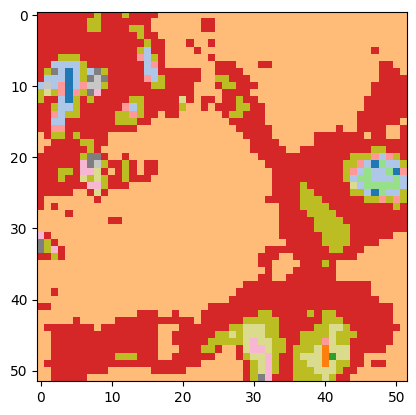

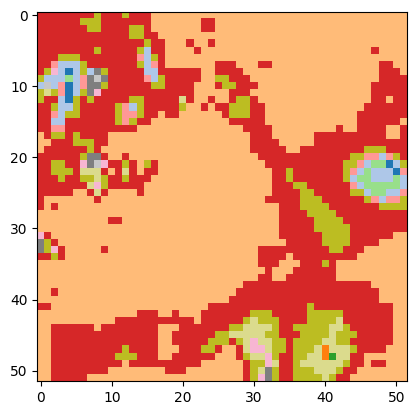

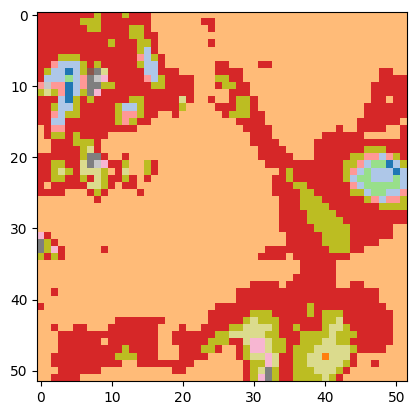

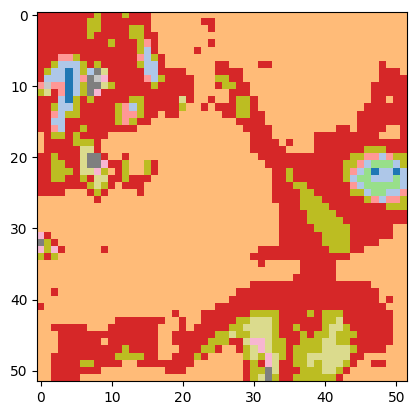

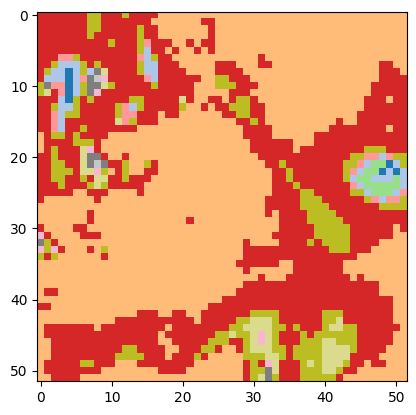

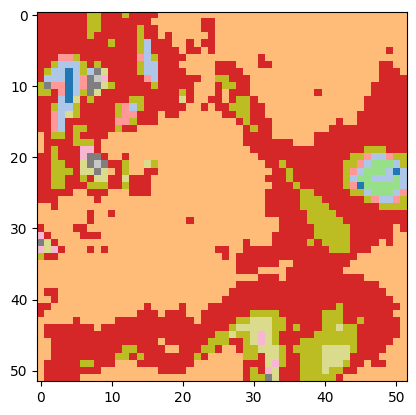

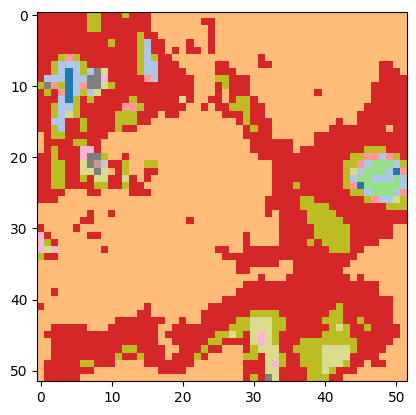

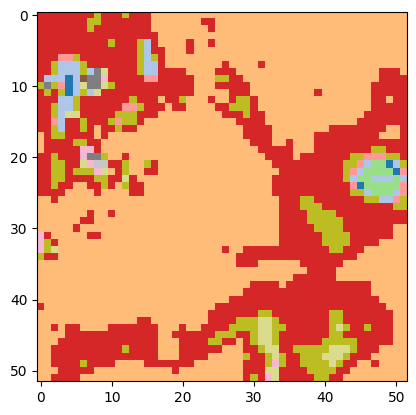

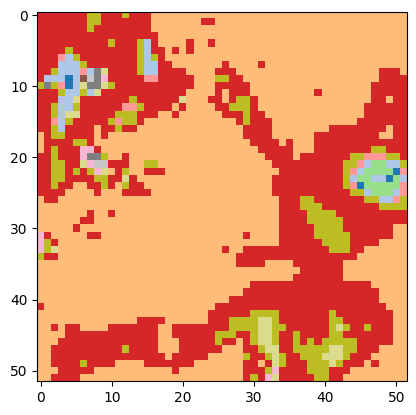

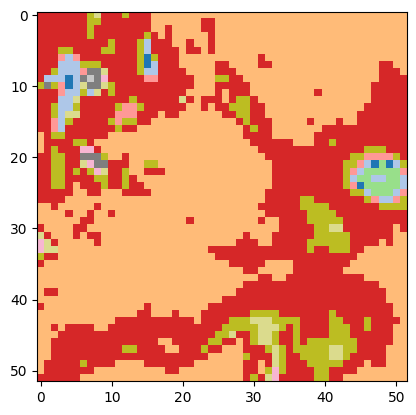

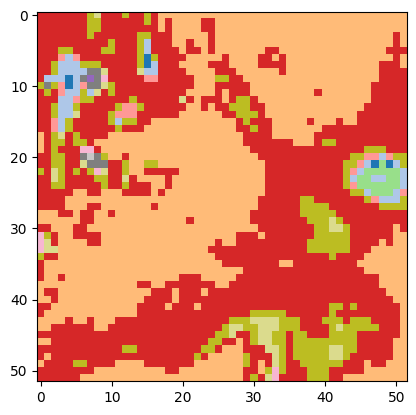

In [194]:
for x in ground:
    rgb = vis_utils.display_labeled_as_rgb(x, preserve_indices=True)
    plt.imshow(rgb)
    plt.show()

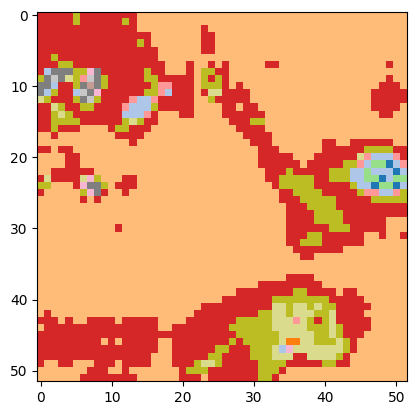

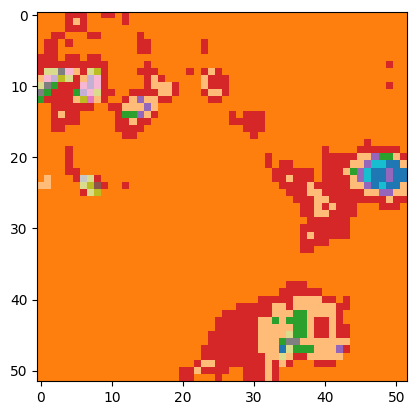

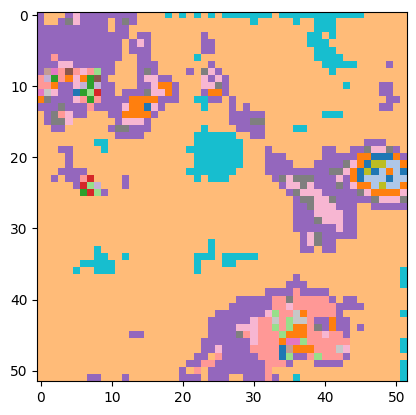

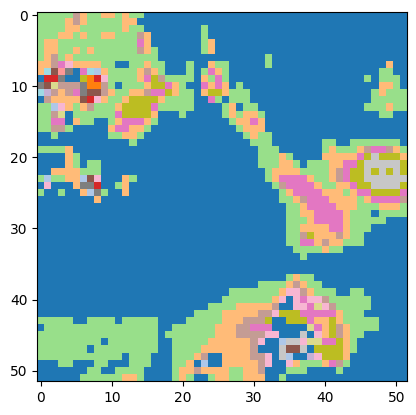

In [192]:
idx = 60
for x in [ground, r2, r4, r8]:
    rgb = vis_utils.display_labeled_as_rgb(x[idx], preserve_indices=True)
    plt.imshow(rgb)
    plt.show()